In [36]:
import pandas as pd


def get_top_features(
    ideology: str, dismiss_common: bool = True, threshold: int = 0.03
):
    sign_features_df = pd.read_csv(
        "data/significant_test/summary_training_effect.csv"
    )
    if dismiss_common:
        sign_features_df = sign_features_df[
            (sign_features_df["label"] == ideology)
        ]
    else:
        sign_features_df = sign_features_df[
            (sign_features_df["label"] == "same")
            | (sign_features_df["label"] == "opposite")
        ]
    col = f"absolute_effect_{ideology}"

    sign_features_df = sign_features_df[
        (
            (sign_features_df["feature"].str.endswith("ratio"))
            & (sign_features_df["feature"].str.startswith("hedge"))
        )
        | (~sign_features_df["feature"].str.endswith("ratio"))
    ]
    sign_features_df = sign_features_df.sort_values(
        by=[col, "feature"], ascending=False
    )
    sign_features_df = sign_features_df[sign_features_df[col] > threshold]

    def _apply_format_feature_name(row):
        feature_name = row["feature"].replace("_ratio", "")
        arr = feature_name.split("_")
        feature_formatted = f"{arr[0]}:{'_'.join(arr[1:])}"
        feature_formatted = feature_formatted.replace("hartmann_", "")
        feature_formatted = feature_formatted.replace(
            "inconsistency", "inconsist."
        )
        feature_formatted = feature_formatted.replace(
            "mpqa", "arg"
        )
        row["feature_formatted"] = feature_formatted.replace(
            "argumentative", "argument"
        )
        return row

    sign_features_df = sign_features_df.apply(
        _apply_format_feature_name, axis=1
    )

    if not dismiss_common:
        sign_features_df = sign_features_df[
            [
                "feature_formatted",
                "effective ineffective_liberal",
                "effective ineffective_conservative",
            ]
        ]
        sign_features_df = sign_features_df.rename(
            columns={
                "feature_formatted": "Style Feature",
                "effective ineffective_liberal": "Lib.",
                "effective ineffective_conservative": "Cons.",
            }
        )
    else:
        sign_features_df = sign_features_df[
            ["feature_formatted", f"effective ineffective_{ideology}"]
        ]
        sign_features_df = sign_features_df.rename(
            columns={
                "feature_formatted": "Style Feature",
                f"effective ineffective_{ideology}": f"{ideology.capitalize()}",
            }
        )
    sign_features_df = sign_features_df.set_index(["Style Feature"])
    return sign_features_df

In [73]:
len(get_top_features("liberal" ,threshold=0.00, dismiss_common=False))

72

In [37]:
sf_common = get_top_features("liberal", threshold=0.02, dismiss_common=False)[
    :15
]

sf_common

,Lib.,Cons.
Style Feature,,
hedge:I,0.11,0.09
liwc:OtherP,0.06,0.05
hedge:D,0.06,0.05
liwc:shehe,0.05,0.04
liwc:AllPunc,0.05,0.03
arg:argument,0.04,0.04
liwc:prosocial,0.04,0.03
liwc:polite,0.04,0.03
liwc:male,0.04,0.04


In [74]:
sf_liberal = get_top_features("liberal", threshold=0.0)
len(sf_liberal)

14

In [77]:
72+14+15

101

In [75]:
sf_conservative = get_top_features("conservative", threshold=0.0)
len(sf_conservative)


15

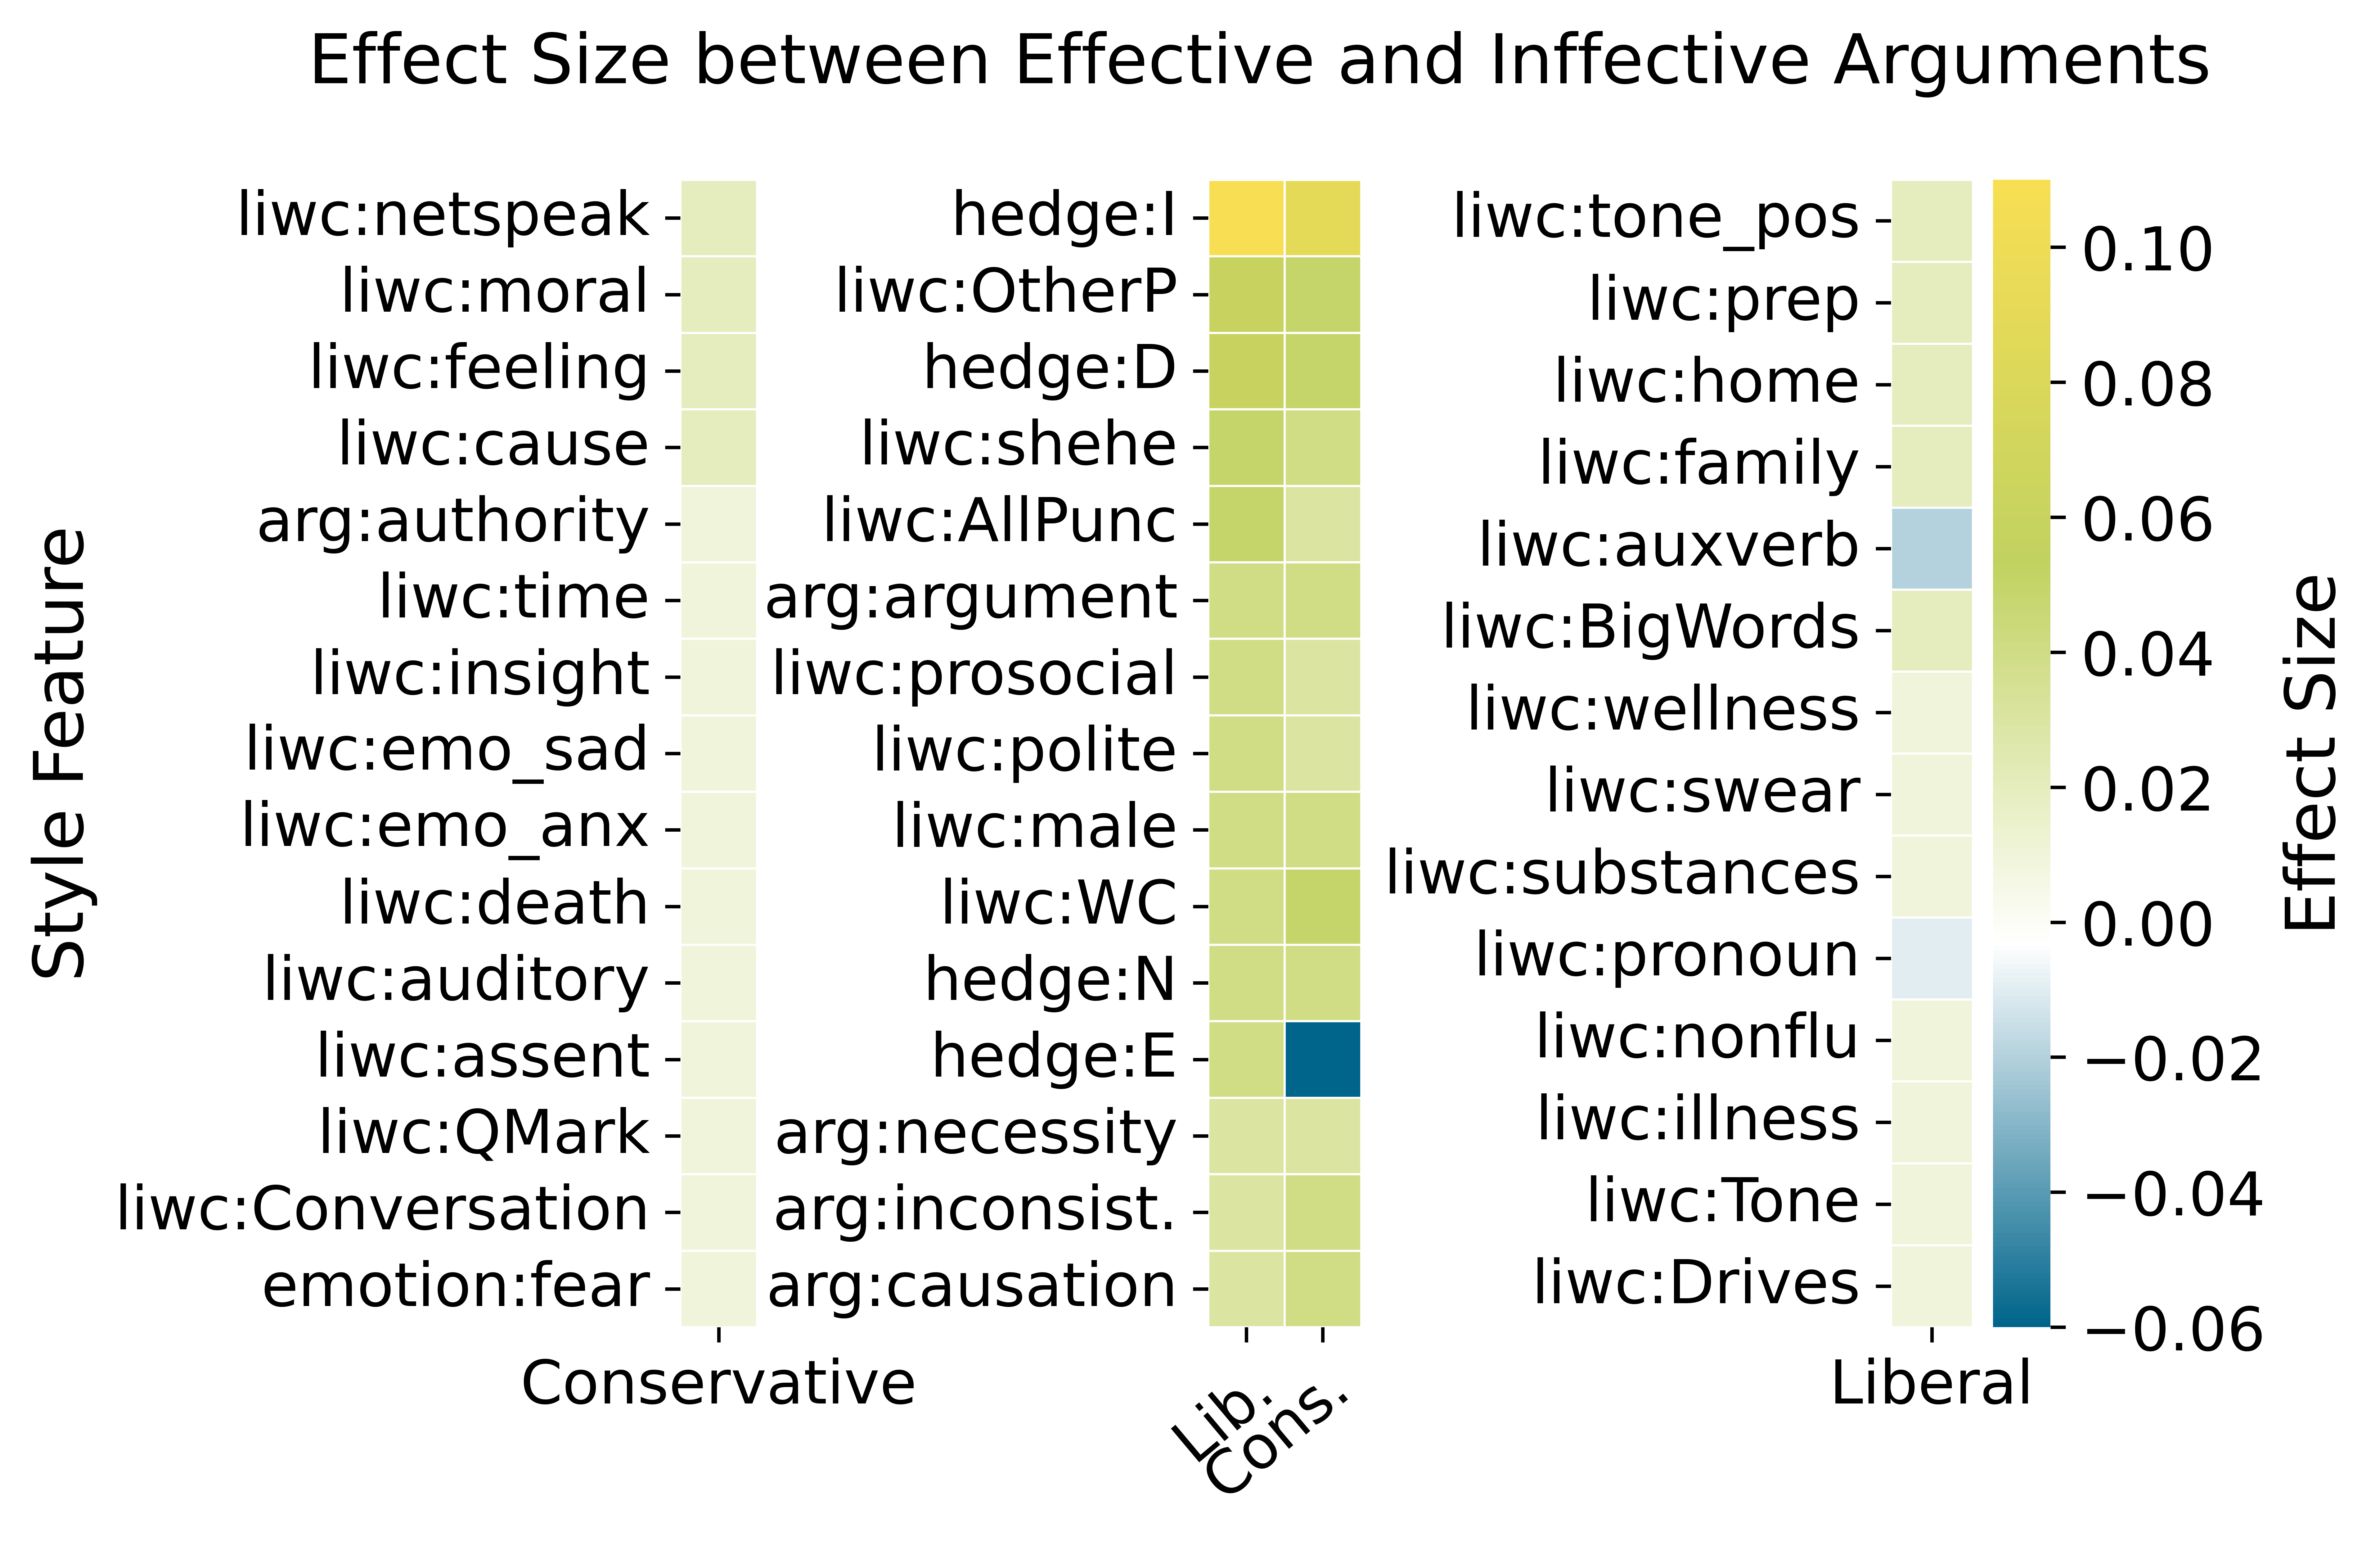

In [72]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and axes
f, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[0.3, 0.4, 0.3], dpi=1000)  # , sharey=True)

# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the heatmaps
data = {
    "Conservative": sf_conservative,
    "Common": sf_common,
    "Liberal": sf_liberal,
}

counter = 0
for k, v in data.items():
    if counter == 2:
        sns.heatmap(
            v,
            ax=ax[counter],
            square=True,
            linewidth=0.5,
            vmin=-0.06,
            vmax=0.11,
            cmap=cmap_dlr,
            cbar=True,
            xticklabels=True,
            cbar_kws={"label": "Effect Size"},
        )

    else:
        sns.heatmap(
            v,
            ax=ax[counter],
            square=True,
            linewidth=0.5,
            vmin=-0.06,
            vmax=0.11,
            cmap=cmap_dlr,
            cbar=False,
            xticklabels=True,
        )

    # ax[counter].invert_yaxis()
    ax[counter].tick_params(labelrotation=0, labelsize=12)
    if k == "Common":
        ax[counter].set_xticklabels(
            ax[counter].get_xticklabels(),
            rotation=40,
            fontsize=14,
            ha="right",
            rotation_mode="anchor",
        )
    else:
        ax[counter].set_xticklabels(ax[counter].get_xticklabels(), fontsize=14)
    ax[counter].set_yticklabels(ax[counter].get_yticklabels(), fontsize=14)
    ax[counter].set_ylabel(f"", size=0)
    # plt.tick_params(labelsize=8)# Show the plot
    counter = counter + 1
ax[0].set_ylabel(f"Style Feature", size=16)
for ax in f.get_axes():
    # ax.tick_params(labelbottom=False, bottom=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
# Adjust the layout
# f.tight_layout()
f.axes[-1].yaxis.label.set_size(16)
f.axes[-1].tick_params(labelrotation=0, labelsize=14)
f.suptitle(
    f"Effect Size between Effective and Inffective Arguments", fontsize=16
)
# plt.subplots_adjust(hspace=300000)
# f.tight_layout()
# f.savefig("original_heatmap.pdf", dpi=300)
f.savefig("original_heatmap.pdf", bbox_inches="tight",dpi=1000)
plt.show()

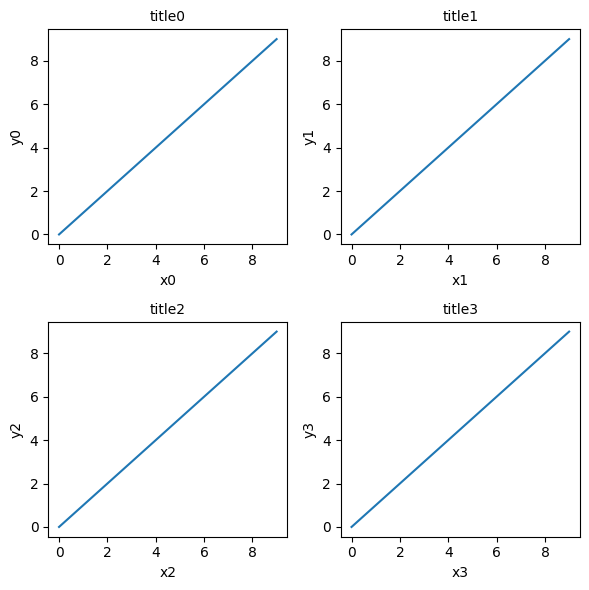

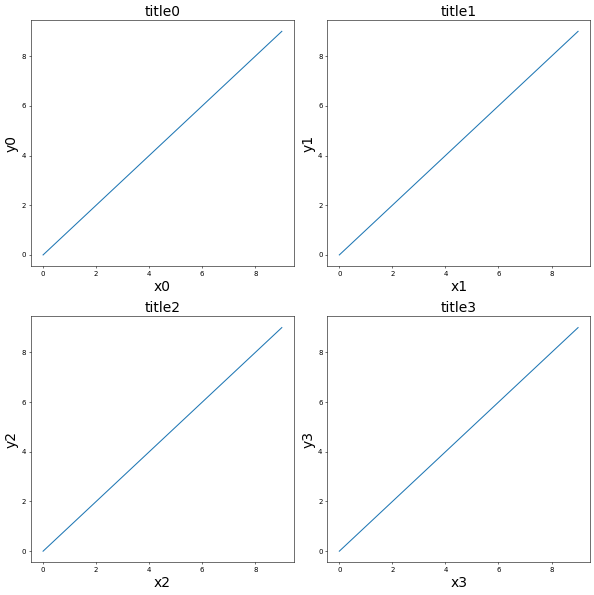

In [52]:
import matplotlib.pyplot as plt

#First normal figure
fig1, axarr1 = plt.subplots(2,2, figsize=(6,6), dpi=100)
for i,ax in enumerate(axarr1.flatten()):
    ax.plot(range(10))
    ax.set_title('title'+str(i), fontsize=10)
    ax.set_xlabel('x'+str(i), fontsize=10)
    ax.set_ylabel('y'+str(i), fontsize=10)
plt.tight_layout()

fig2, axarr2 = plt.subplots(2,2, figsize=(12,12), dpi=50)
for i,ax in enumerate(axarr2.flatten()):
    ax.plot(range(10))
    ax.set_title('title'+str(i), fontsize=20)
    ax.set_xlabel('x'+str(i), fontsize=20)
    ax.set_ylabel('y'+str(i), fontsize=20)
plt.tight_layout()


In [3]:
rgb_vals = ((0, 101, 139), (248, 222, 83), (0, 148, 168), (193, 210, 96))
# #00658B   0, 101, 139
# #F8DE53    248, 222, 83
# #0094A8 0, 148, 168
# #C1D260 193, 210, 96
import seaborn as sns
cmap_dlr = sns.blend_palette(
    ("#00658B", "#ffffff", "#C1D260", "#F8DE53"), as_cmap=True
)

In [149]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43156001218774975, 0.6160490836499025, 0.6735874169971766),
 (0.611122882611058, 0.7333644584921324, 0.7720145556336929),
 (0.7906857530343663, 0.8506798333343624, 0.8704416942702093),
 (0.95, 0.95, 0.95),
 (0.9282549678814984, 0.7863704363662967, 0.7963965173228867),
 (0.9022582584936525, 0.6005186021022944, 0.622400049291663),
 (0.8762615491058064, 0.4146667678382919, 0.44840358126043944),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

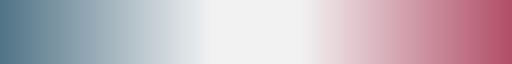

In [150]:
cmap_dlr_div = sns.diverging_palette(
    h_neg=229, h_pos=359, s=52, l=47, sep=46, n=10, as_cmap=True
)
cmap_dlr_div

In [1]:
rgb_vals = ((0, 101, 139), (248, 222, 83), (0, 148, 168), (193, 210, 96))

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

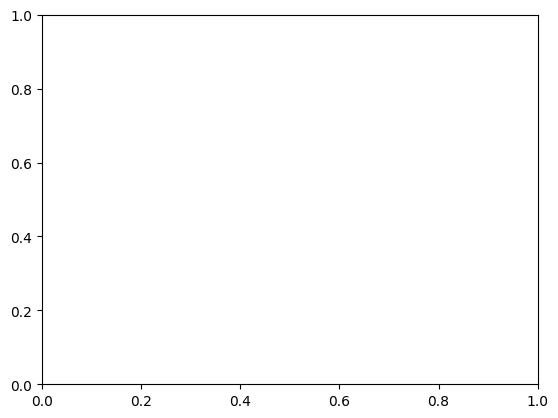

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Define the data for each experiment
experiment_1 = {"toxic": [10, 5], "non-toxic": [5, 10]}
experiment_2 = {"toxic": [8, 4], "non-toxic": [4, 8]}
experiment_3 = {"toxic": [6, 3], "non-toxic": [3, 6]}

# Create a list of experiments
experiments = [experiment_1, experiment_2, experiment_3]

# Set the colors for the different types of responses
colors = ["blue", "green"]

# Plot the stacked bars
fig, ax = plt.subplots()
sns.barplot([x + 1 for x in range(len(experiments))],
             [[y["toxic"], y["non-toxic"]] for y in experiments],
             labels=[r"Toxic", r"Non-toxic"])

# Add legend
ax.legend()

plt.show()